
# **Transfer learning**

<pre>
Deep Learning with Python and Lua - Home Assignment 4

<i>Author: Nyikovics Máté</i>
<i>Objective:</i> <a href="https://github.com/BME-SmartLab-Education/vitmav45/blob/master/kishazi/4-kis-hazi-feladat.md">Home Assignment 4 GitHub</a>
2019.11.19.
</pre>

In [0]:
from tqdm import tqdm_notebook as tqdm
import requests
import pandas as pd
import time
import os
from typing import List, Tuple
import cv2
import tensorflow as tf
import numpy as np

In [0]:
def download_file(url: str, full_path: str, disable_progress_bar: bool = False) -> None:
    """
    Downloads a file with the given url over http.
    :param url: the url to donwload from
    :param full_path: the full path in which to save the file (usually directory + filename, eg. /content/file.txt)
    :param disable_progress_bar: if True, hides the progress bar  
    :return: None
    """
    time.sleep(0.1) # give 0.1 sec to the stdout to get ready for the following progress bar action 
    # streaming to be able to iterate over the response
    r = requests.get(url, stream=True)
    total_size = int(r.headers.get('content-length', 0))    # in bytes
    download_size = 0
    block_size = 1024 #1 KB
    t=tqdm(total=total_size, unit='iB', unit_scale=True, disable=disable_progress_bar)
    # write out the file
    with open(full_path, 'wb') as f:
        for data in r.iter_content(block_size):
            t.update(len(data))
            download_size += len(data)
            f.write(data)
    t.close()
    if total_size != 0 and download_size != total_size:
        raise Exception(f"Something went wrong while downloading\n{full_path} from\n{url}")
    return full_path

def remove_dir(dir_path: str) -> None:
    """
    Deletes a directory and all of its contents recursively.
    :param dir_path: path to the direcory to delete
    :return: None
    """
    if os.path.exists(dir_path):
        contents = os.scandir(dir_path) # contents is of type List[DirEntry]
        for content in contents:
            if content.is_dir():
                remove_dir(os.path.join(dir_path, content))
            else:
                os.remove(content)
        os.rmdir(dir_path)


## 1. Getting the images

### 1.1 Getting and formatting the metadata

Instead of downloading the huge zip files mentioned in the assignments description, i opted for first downloading the metadata associated with the dataset, and then downloading the images i deemed needed one by one.
By metadata i mean 3 csv files:

*   **class-descriptions.csv**: contained label id - humanly understandable label name associations for each image class
*   **test-images-with-rotation.csv**: contained the test imageset metadata (img source url, filename, author, licence, etc.) 
*   **test-annotations-human-imagelabels.csv**: contained image id - label id associations

I'have chosen the test datasets metadata, because it already contained far more image data than i needed (~125 000 image metadata compared to my need of 3 x 600).

In [0]:
# urls for the metadata csv files 
csv_url_dict = {
    "class_names": "https://storage.googleapis.com/openimages/v5/class-descriptions.csv",
    "image_ids": "https://storage.googleapis.com/openimages/2018_04/test/test-images-with-rotation.csv",    # using the test image dataset, it has more than enough pictures
    "human_labels": "https://storage.googleapis.com/openimages/v5/test-annotations-human-imagelabels.csv"   # using the test image dataset
}

I'm creating the directory structure to store the images.

In [0]:
csv_dir = os.path.join(os.getcwd(), "csv")
img_dir = os.path.join(os.getcwd(), "images")
train_img_dir = os.path.join(img_dir, "train")
test_img_dir = os.path.join(img_dir, "test")
validation_img_dir = os.path.join(img_dir, "validation")
# remove previous data (if any)
remove_dir(csv_dir)
remove_dir(img_dir)
# initialize directory structure
os.mkdir(csv_dir)
os.mkdir(img_dir)
os.mkdir(train_img_dir)
os.mkdir(test_img_dir)
os.mkdir(validation_img_dir)

In [5]:
# download all the csv files
for k, v in csv_url_dict.items():
    print(f"Downloading [{k}] from {v}.")
    full_path = os.path.join(csv_dir, v.split("/")[-1])
    download_file(v, full_path)
    # also parse as a dataframe
    if k == "class_names":
        class_names_df = pd.read_csv(filepath_or_buffer=full_path, sep=",", header=None, names=["LabelName", "HumanLabelName"])
    elif k == "image_ids":
        image_ids_df = pd.read_csv(filepath_or_buffer=full_path, sep=",", header=0, usecols=["ImageID", "OriginalURL", "Rotation"])
    elif k == "human_labels":
        human_labels_df = pd.read_csv(filepath_or_buffer=full_path, sep=",", header=0, usecols=["ImageID", "LabelName", "Confidence"])

In [6]:
class_names_df.tail(2)

,LabelName,HumanLabelName
19983,/m/0zrv5th,Lamborghini huracán
19984,/m/0zvk5,Helmet


In [7]:
image_ids_df.tail(2)

,ImageID,OriginalURL,Rotation
125434,e8c079d13d5c1b2d,https://c6.staticflickr.com/3/2281/5743858979_...,0.0
125435,922a94a13f6fd9bf,https://c8.staticflickr.com/2/1195/1440679806_...,0.0


In [8]:
human_labels_df.tail(2)

,ImageID,LabelName,Confidence
1799881,fffd0258c243bbea,/m/03qtwd,1
1799882,fffd0258c243bbea,/m/02r9rk,0


I'm merging the metadata datasets on ID columns to get one big dataset with all the values i need.

In [9]:
merged_df = human_labels_df.merge(right=image_ids_df, how="left", on="ImageID") \
                           .merge(right=class_names_df, how="left", on="LabelName")
merged_df = merged_df.query("Rotation == 0.0 and Confidence == 1")
merged_df = merged_df.drop(columns=["Rotation", "Confidence", "LabelName"])
merged_df.head()

,ImageID,OriginalURL,HumanLabelName
0,000026e7ee790996,https://farm7.staticflickr.com/5769/2109480371...,Ancient history
1,000026e7ee790996,https://farm7.staticflickr.com/5769/2109480371...,Cloud
3,000026e7ee790996,https://farm7.staticflickr.com/5769/2109480371...,Sky
4,000026e7ee790996,https://farm7.staticflickr.com/5769/2109480371...,Rock
6,000026e7ee790996,https://farm7.staticflickr.com/5769/2109480371...,Tree


I'm filtering the dataset to include those categories, which have more than 600 images associated with them.

In [10]:
grouped_df = merged_df.groupby(by=["HumanLabelName"]) \
                      .count() \
                      .query("ImageID > 600") \
                      .sort_values(by="ImageID", ascending=False) 
print(f"There are {len(grouped_df)} labels, which have more than 600 images associated with them.")
print("The top 3:")
grouped_df.iloc[0:3, 0:1]

There are 232 labels, which have more than 600 images associated with them.
The top 3:


,ImageID
HumanLabelName,
Clothing,18798
Person,18769
Mammal,15847


In [11]:
# choosing 3 arbitrary categories
category_0_label = grouped_df.index.array[50]
category_1_label = grouped_df.index.array[100]
category_2_label = grouped_df.index.array[150]
print("Chosen labels:\n{}".format('\n'.join([category_0_label, category_1_label, category_2_label])))

Chosen labels:
Dog breed
Marine biology
Muscle


### 1.2 Downloading the images

Now that i have all the metadata in a manageable format, and i have picked my 3 categories, all that is left is to download the 600-600-600 images per category label.  

In [0]:
class FileIsNotAValidImageException(Exception):
    """
    Custom exception class to validate an image file.
    """
    pass

In [15]:
# make 3 separate dataframes with the OriginalURL column belonging to the label
category_labels = [category_0_label, category_1_label, category_2_label]
category_file_paths_dict = {}
for category_label in category_labels:
    category_file_path_list = []
    category_url_list = merged_df.query(f"HumanLabelName == '{category_label}'").OriginalURL.unique()  # should be all unique, just to be sure apply the unique() function
    print(f"Downloading 600 images for category '{category_label}'")
    tt = tqdm(total=600, unit='it', unit_scale=True)  # progress bar
    idx = 0  # index indicating the successfully downloaded image count 
    for url in category_url_list:
        # the urls are pointing directly to the image files, so
        # i can get the extension from that 
        ext = url.split(".")[-1]
        name = category_label.lower().replace(" ", "_")
        filename = f"{name}_{idx:03d}.{ext}"
        try:
            # if i've reached 600 downloaded images, stop the cycle
            if idx == 600:
                break
            elif 500 <= idx < 600:
                full_path = os.path.join(test_img_dir, filename)
            elif 400 <= idx < 500:
                full_path = os.path.join(validation_img_dir, filename)
            else:
                full_path = os.path.join(train_img_dir, filename)
            download_file(url, full_path, True)
            # try to parse file as an image to verify it's integrity
            if cv2.imread(full_path) is None:
                raise FileIsNotAValidImageException()
            category_file_path_list.append(full_path)
            idx += 1
            tt.update(1)
        except (requests.exceptions.RequestException, FileIsNotAValidImageException):
            # if i could not download an image (for various expected reasons), ignore the exception, try another one 
            pass
    tt.close()
    assert idx == 600, f"Ran out of url-s for category '{category_label}' before reaching total 600 images (got {idx})."
    category_file_paths_dict[category_label] = category_file_path_list
    time.sleep(0.1) # wait a sec for stdout 

## 2. Transfer learning

### 2.1 Building the model

For the transfer learning part i'm using the inbuilt ResNet50 model from keras with the pre-trained weights, and the default (224, 224, 3) image input shape as my base model. On top of this i've got an average pooling layer and 2 dense layers, the last one with softmax activation. 

In [38]:
# get ResNet50 as base model with pretrained weights, but without the last few (classifier) layers
input_shape = (224, 224, 3)  # the default input shape for ResNet50 (in channel_last format)
base_model = tf.keras.applications.ResNet50(weights="imagenet", include_top=False, input_shape=input_shape)
# construct my own classification layers
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1024, activation="relu")(x)
# the final classifier layer with the nr. of classes as output (3 in my case)
output = tf.keras.layers.Dense(3, activation="softmax")(x)

model = tf.keras.models.Model(inputs=base_model.input, outputs=output)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [0]:
def print_trainable_layers(model: tf.keras.models.Model) -> None:
    """
    Prints the names of all trainable layers in a keras model. 
    """
    print(f"Trainable layers for '{model.name}':")
    total_layer_cnt = len(model.layers)
    for idx, layer in enumerate(model.layers):
        if layer.trainable:
            print(f"[{idx+1}/{total_layer_cnt}] {layer.name}")

def train_data_generator(batch_size: int) -> Tuple[np.ndarray, np.ndarray]:
    """
    Train data generator.
    :param batch_size: nr. of images to generate
    :yield: batch_size nr. of images and the corresponding labels in one-hot encoded format 
    """
    x = np.zeros(shape=(batch_size, input_shape[0], input_shape[1], input_shape[2]))
    y = np.zeros(shape=(batch_size, len(category_labels)))
    while True:
        for i in range(batch_size):
            # pick an index form the train dataset index range
            r_idx = np.random.randint(0, 400)
            # pick an index from the 0-3 (nr. of category labels) range   
            r_label_idx = np.random.randint(0, len(category_labels))
            # get the full category name   
            category_label = category_labels[r_label_idx]
            # get the random image
            img_path = category_file_paths_dict[category_label][r_idx]
            img = cv2.imread(img_path, cv2.IMREAD_COLOR)
            img = cv2.resize(img, (input_shape[0], input_shape[1]))
            # one-hot encode the category label index for image classification
            category_label_one_hot = np.zeros(shape=(len(category_labels)))
            category_label_one_hot[r_label_idx] = 1
            x[i] = img
            y[i] = category_label_one_hot
        yield x,y

def validation_data_generator(batch_size: int) -> Tuple[np.ndarray, np.ndarray]:
    """
    Validation data generator.
    :param batch_size: nr. of images to generate
    :yield: batch_size nr. of images and the corresponding labels in one-hot encoded format 
    """
    x = np.zeros(shape=(batch_size, input_shape[0], input_shape[1], input_shape[2]))
    y = np.zeros(shape=(batch_size, len(category_labels)))
    while True:
        for i in range(batch_size):
            # pick an index form the validation dataset index range
            r_idx = np.random.randint(400, 500) 
            r_label_idx = np.random.randint(0, len(category_labels))
            category_label = category_labels[r_label_idx]
            img_path = category_file_paths_dict[category_label][r_idx]
            img = cv2.imread(img_path, cv2.IMREAD_COLOR)
            img = cv2.resize(img, (input_shape[0], input_shape[1]))
            category_label_one_hot = np.zeros(shape=(len(category_labels)))
            category_label_one_hot[r_label_idx] = 1
            x[i] = img
            y[i] = category_label_one_hot
        yield x,y

def test_data_generator(batch_size: int) -> Tuple[np.ndarray, np.ndarray]:
    """
    Test data generator.
    :param batch_size: nr. of images to generate
    :yield: batch_size nr. of images and the corresponding labels in one-hot encoded format 
    """
    x = np.zeros(shape=(batch_size, input_shape[0], input_shape[1], input_shape[2]))
    y = np.zeros(shape=(batch_size, len(category_labels)))
    while True:
        for i in range(batch_size):
            # pick an index form the test dataset index range
            r_idx = np.random.randint(500, 600)   
            r_label_idx = np.random.randint(0, len(category_labels)) 
            category_label = category_labels[r_label_idx]
            img_path = category_file_paths_dict[category_label][r_idx]
            img = cv2.imread(img_path, cv2.IMREAD_COLOR)
            img = cv2.resize(img, (input_shape[0], input_shape[1]))
            category_label_one_hot = np.zeros(shape=(len(category_labels)))
            category_label_one_hot[r_label_idx] = 1
            x[i] = img
            y[i] = category_label_one_hot
        yield x,y

### 2.1 Starting the training

For the training i'm using:

*  batch_size=20
*  epochs=4
*  steps_per_epoch=2

this way in one training iteration i'm covering 20x4x2=160 images, approximately 1/3 of the whole training set. I could easily push these numbers, but the model trains so quickly and accurately with these already, that i thought it would mitigate / defeat the purpose of the following fine-tuning step.

In [40]:
# initialize the generators
batch_size = 20
train_gen = train_data_generator(batch_size)
validation_gen = validation_data_generator(batch_size)
test_gen = test_data_generator(batch_size)

# first train only the newly added classifier layers
for layer in base_model.layers:
    layer.trainable = False

print_trainable_layers(model)

Trainable layers for 'model_2':
[176/178] global_average_pooling2d_2
[177/178] dense_4
[178/178] dense_5


In [0]:
def show_result(model: tf.keras.models.Model) -> None:
    """
    Helper function to plot prediction images.
    """
    import matplotlib.pyplot as plt
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3, figsize=(8,8))
    fig.subplots_adjust(hspace=0.2, wspace=0.2)

    # using the test generator predict 9 images
    test_gen = test_data_generator(9)
    img_list, label_list = next(test_gen)
    pred_label_list = model.predict(x=img_list, batch_size=9, verbose=0)

    for i, ax in enumerate(axes.flat):
        rgb_img = img_list[i][...,::-1]
        ax.imshow(rgb_img/255)
        # decode one hot encoding
        category_idx = np.argmax(label_list[i], axis=0)
        pred_category_idx = np.argmax(pred_label_list[i], axis=0)
        # get the category name
        category_label = category_labels[category_idx]
        pred_category_label = category_labels[pred_category_idx]
        # show true and predicted classes.
        xlabel = f"True: {category_label},\nPred: {pred_category_label}"

        # show the classes as the label on the x-axis.
        # show it in red if false prediction
        if category_idx != pred_category_idx:
            ax.set_xlabel(xlabel, {"color": "red"})
        else:
            ax.set_xlabel(xlabel, {"color": "green"})
        
        # remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

In [0]:
# compiling the model, preparing for training
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=[tf.keras.metrics.CategoricalCrossentropy(), 'acc'])

Starting model loss: 1.1248144686222077, accuracy: 0.4000000059604645, crossentropy: 1.124814510345459


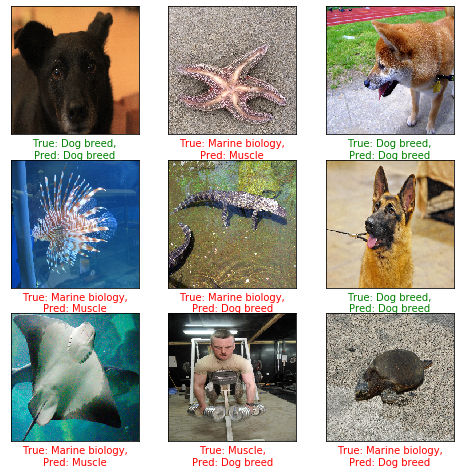

In [43]:
# evaluate starting model accuracy over 10 steps
ev_loss, ev_crossentropy, ev_accuracy = model.evaluate_generator(generator=test_gen, steps=10)
print(f"Starting model loss: {ev_loss}, accuracy: {ev_accuracy}, crossentropy: {ev_crossentropy}")
show_result(model)

Training classifier layers...
Epoch 1/4
2/2 [==============================] - 26s 13s/step - loss: 1.4430 - categorical_crossentropy: 1.4430 - acc: 0.6250 - val_loss: 12.6179 - val_categorical_crossentropy: 12.6179 - val_acc: 0.5700
Epoch 2/4
2/2 [==============================] - 23s 12s/step - loss: 8.7653 - categorical_crossentropy: 8.7653 - acc: 0.5250 - val_loss: 7.3114 - val_categorical_crossentropy: 7.3114 - val_acc: 0.4700
Epoch 3/4
2/2 [==============================] - 29s 15s/step - loss: 1.7875 - categorical_crossentropy: 1.7875 - acc: 0.7250 - val_loss: 0.0663 - val_categorical_crossentropy: 0.0663 - val_acc: 0.9800
Epoch 4/4
2/2 [==============================] - 26s 13s/step - loss: 0.3399 - categorical_crossentropy: 0.3399 - acc: 0.8750 - val_loss: 1.1725 - val_categorical_crossentropy: 1.1725 - val_acc: 0.8200
Finished training for 4 epochs.
Current model loss: 0.7861586935818196, accuracy: 0.8799999952316284, crossentropy: 0.7861587405204773


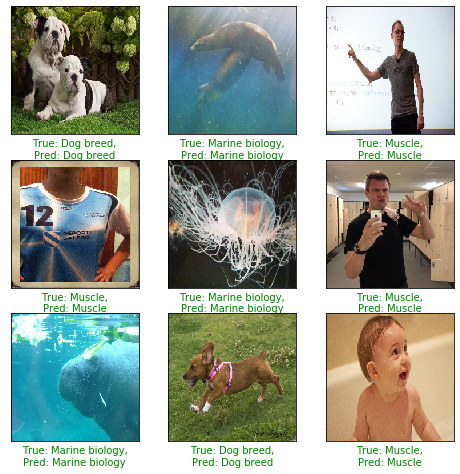

In [44]:
# train the classifier layers
print("Training classifier layers...")
epochs = 4
model.fit_generator(generator=train_gen, steps_per_epoch=2, epochs=epochs, validation_data=validation_gen, validation_steps=5, verbose=1, use_multiprocessing=True)
print(f"Finished training for {epochs} epochs.")
# evaluate current model accuracy over 10 steps
ev_loss, ev_crossentropy, ev_accuracy = model.evaluate_generator(generator=test_gen, steps=10, use_multiprocessing=True)
print(f"Current model loss: {ev_loss}, accuracy: {ev_accuracy}, crossentropy: {ev_crossentropy}")
show_result(model)

### 2.2 Fine-tuning the model

In [45]:
# fine-tuning additional convolution layers, setting the last convolution block (conv5) also trainable
for layer in base_model.layers:
    if "conv5_block" in layer.name:
        layer.trainable = True
print_trainable_layers(model)
# recompile the model for fine-tuning
# i'm using gradient descent with momentum and lower learning rate over rmsprop to keep converging to the minima
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=[tf.keras.metrics.CategoricalCrossentropy(), 'acc'])

Trainable layers for 'model_2':
[144/178] conv5_block1_1_conv
[145/178] conv5_block1_1_bn
[146/178] conv5_block1_1_relu
[147/178] conv5_block1_2_conv
[148/178] conv5_block1_2_bn
[149/178] conv5_block1_2_relu
[150/178] conv5_block1_0_conv
[151/178] conv5_block1_3_conv
[152/178] conv5_block1_0_bn
[153/178] conv5_block1_3_bn
[154/178] conv5_block1_add
[155/178] conv5_block1_out
[156/178] conv5_block2_1_conv
[157/178] conv5_block2_1_bn
[158/178] conv5_block2_1_relu
[159/178] conv5_block2_2_conv
[160/178] conv5_block2_2_bn
[161/178] conv5_block2_2_relu
[162/178] conv5_block2_3_conv
[163/178] conv5_block2_3_bn
[164/178] conv5_block2_add
[165/178] conv5_block2_out
[166/178] conv5_block3_1_conv
[167/178] conv5_block3_1_bn
[168/178] conv5_block3_1_relu
[169/178] conv5_block3_2_conv
[170/178] conv5_block3_2_bn
[171/178] conv5_block3_2_relu
[172/178] conv5_block3_3_conv
[173/178] conv5_block3_3_bn
[174/178] conv5_block3_add
[175/178] conv5_block3_out
[176/178] global_average_pooling2d_2
[177/178]

Fine-tuning layers...
Epoch 1/4
2/2 [==============================] - 41s 20s/step - loss: 0.5524 - categorical_crossentropy: 0.5524 - acc: 0.8750 - val_loss: 1.2675 - val_categorical_crossentropy: 1.2675 - val_acc: 0.8100
Epoch 2/4
2/2 [==============================] - 25s 12s/step - loss: 0.3747 - categorical_crossentropy: 0.3747 - acc: 0.9000 - val_loss: 1.2087 - val_categorical_crossentropy: 1.2087 - val_acc: 0.8200
Epoch 3/4
2/2 [==============================] - 25s 12s/step - loss: 1.0062 - categorical_crossentropy: 1.0062 - acc: 0.7750 - val_loss: 1.1166 - val_categorical_crossentropy: 1.1166 - val_acc: 0.8200
Epoch 4/4
2/2 [==============================] - 26s 13s/step - loss: 0.1823 - categorical_crossentropy: 0.1823 - acc: 0.9750 - val_loss: 1.0130 - val_categorical_crossentropy: 1.0130 - val_acc: 0.8500
Finished training for 4 epochs.
Final model loss: 0.645296648517251, accuracy: 0.8949999809265137, crossentropy: 0.6452966332435608


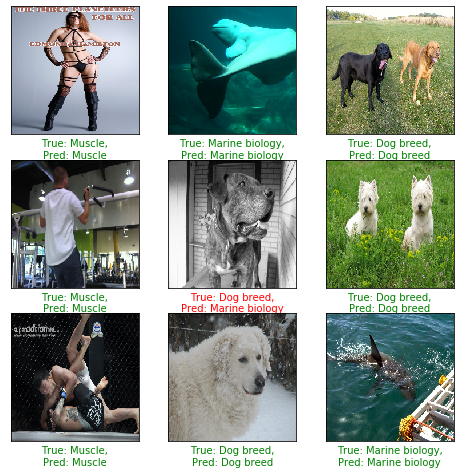

In [46]:
# fine-tune the model
print("Fine-tuning layers...")
epochs = 4
model.fit_generator(generator=train_gen, steps_per_epoch=2, epochs=epochs, validation_data=validation_gen, validation_steps=5, verbose=1, use_multiprocessing=True)
print(f"Finished training for {epochs} epochs.")
# evaluate final model accuracy over 10 steps
ev_loss, ev_crossentropy, ev_accuracy = model.evaluate_generator(generator=test_gen, steps=10, use_multiprocessing=True)
print(f"Final model loss: {ev_loss}, accuracy: {ev_accuracy}, crossentropy: {ev_crossentropy}")
show_result(model)

## 3. Conclusion

One can easily see the power of transfer learning. With just 1800 images and a few minutes of training i could achive near perfect accuracy, minimize the loss, in one word to adjust / optimize the model to my own needs (the 3 categories). 